In [1]:
import keras
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import sqrt

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import joblib

import pickle
import multiprocessing

import tracer



flopy is installed in /home/judap/source/miniconda3/envs/popex-jebut/lib/python3.8/site-packages/flopy


## Context: the tracer test as forward in the inverse problem

We generated a synthetic geological 2D reference which contains 4 geological facies.
With each facies a permeability, conductivity and specific storage valueis uniquely assigned.
The permeability, conductivity and specific storage are parameters needed to solve transport problem of a tracer, which is injected at x=25, y=50. A pumping well is placed at x=75, y=50 and concentration of the tracer is measured during 20 days.
A geology maps uniquely to the concentration curve. Then, the concentration curve is used to compute the likelihood of the model.

During the solution of the inverse problem, geological models are generated and the concentration curve is computed for each model using MODFLOW with transport module. However, MODFLOW computation is very expensive (around 30 min per simulation). We would like to limit the number of MODFLOW calls. First, we generate 500 pairs geology and concentration. Using this dataset, we want to train a ML model that would estimate the siginificance of likelihood (high/low) of new models.

The goal is to use Machine Learning (ML) to map from the geology 2D categorical image 100x100 to the likelihood class (good=high=1, bad=low=0).

In [2]:
with open('ref/ref-img-val.pickle', 'rb') as file_handle:
    img_ref = pickle.load(file_handle)

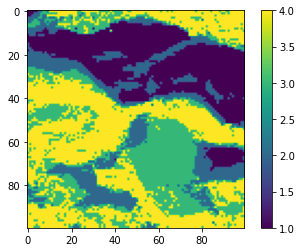

In [3]:
# the reference geology
plt.imshow(img_ref)
plt.colorbar()

In [4]:
def normed(x, xmax, xmin):
    return (x-xmin)/(xmax-xmin)

In [5]:
def backnormed(x, xmax, xmin):
    return x*(xmax-xmin)+xmin

In [6]:
def img_to_k(img):
    k = np.array(img, dtype='float32', copy=True)
    k[k==4] = 1e-1
    k[k==3] = 1e-3
    k[k==2] = 1e-4
    k[k==1] = 1e-5
    #return normed(k, 1e-1, 1e-5)
    return k

def img_to_porosity(img):
    porosity = np.array(img, dtype='float32', copy=True)
    porosity[porosity==4] = 0.25
    porosity[porosity==3] = 0.30
    porosity[porosity==2] = 0.35
    porosity[porosity==1] = 0.40
    #return normed(porosity, 0.4, 0.25)
    return porosity

def img_to_specificstorage(img):
    ss = np.array(img, dtype='float32', copy=True)
    ss[ss==4] = 1e-5
    ss[ss==3] = 1e-4
    ss[ss==2] = 5e-4
    ss[ss==1] = 1e-3
    return normed(ss, 1e-3, 1e-5)

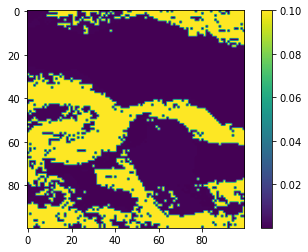

In [7]:
plt.imshow(img_to_k(img_ref))
plt.colorbar()

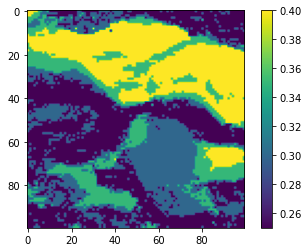

In [8]:
plt.imshow(img_to_porosity(img_ref))
plt.colorbar()

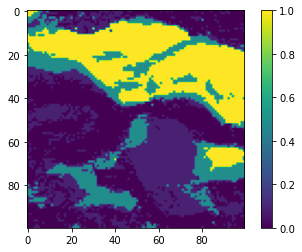

In [9]:
plt.imshow(img_to_specificstorage(img_ref))
plt.colorbar()

In [10]:
with open('ref/measurement-4.pickle', 'rb') as file_handle:
    concentrations_ref = pickle.load(file_handle)

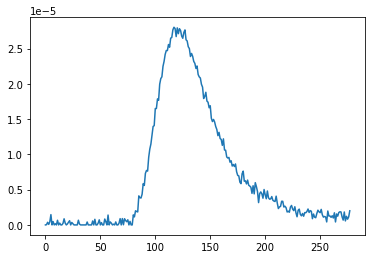

In [11]:
# the reference concentration curve
plt.plot(concentrations_ref[:])

For computation of the likelihood only 6 values sampled from the concentration cruve are used.
They are sampled at the following indexes:

In [12]:
ind = [50, 100, 125, 150, 200, 250]

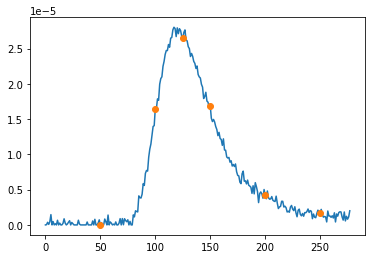

In [13]:
# the reference concentration curve
plt.plot(concentrations_ref[:])
plt.plot(ind, concentrations_ref[ind], 'o')

We can either use ML to estimate the mismatch directly, or try to estimate the 6 values on the concentration curve, or output YES/NO if mismatch is among 100 best.

I propose the following approach: use conductivity, porosity and specific storage. It results in (100,100,3) array for each model, filled with positive values. Normalize them. Then train a ML classifier on yes/no whether the model is among the 10% best in terms of likelihood.

## The dataset

In [14]:
N_POPEX = 500
# helper popex object
with open(f'popex-{N_POPEX}/popex.pop', 'rb') as file_handle:
    popex_object = pickle.load(file_handle)

In [15]:
def get_pickle(name):
    result = None
    try:
        with open(name, 'rb') as file_handle:
            result = pickle.load(file_handle)
    except FileNotFoundError as e:
        print(f'{name} failed: {str(e)}')
    return result

In [16]:
def get_vx(heads):
    vx = (heads[2:,:] - heads[:-2,:]) / 2
    return vx[:,1:-1]

def get_vy(heads):
    vy = (heads[:,2:] - heads[:,:-2]) / 2
    return vy[1:-1,:]

def get_red_porosity(porosity):
    return porosity[1:-1, 1:-1]

In [17]:
def _compute_heads(img, name, popex_dir, write_pickle=True):
    steady_state = tracer.TracerTest(cell_divisions=1, working_dir='modflow-steady-500')
    steady_state.run_steady(img, name=name)
    heads = steady_state.get_heads(name=name)
    if write_pickle:
        with open(_heads_file(name, popex_dir=popex_dir), 'wb') as file_handle:
            pickle.dump(heads, file_handle)
    steady_state.remove_modflow_workspace(name=name)
    return heads

def _compute_heads_from_tuple(img_tuple, popex_dir):
    for i,img in enumerate(img_tuple):
        name = f'{i}'
        _compute_heads(img, name, popex_dir)
        

def _heads_file(name, popex_dir):
    return f'heads-500/heads-{name}.pickle'

In [18]:
# load "good" concentrations
concentration_tuple = tuple(get_pickle(f'concentrations-{N_POPEX}/flow-{i}-concentration.pickle') for i in range(N_POPEX))
model_tuple = tuple(get_pickle(f'popex-{N_POPEX}/{i}') for i in popex_object.model[:N_POPEX])
img_tuple = tuple(i[0].param_val.reshape((100,100)) for i in model_tuple)

In [19]:
try:
    heads_transformed_tuple = tuple(get_pickle(f'heads-{N_POPEX}/heads-{i}.pickle')[0,0,:,:]+0.5 for i in range(N_POPEX))
except TypeError:
    _compute_heads_from_tuple(img_tuple, 'popex-500')
    heads_transformed_tuple = tuple(get_pickle(f'heads-{N_POPEX}/heads-{i}.pickle')[0,0,:,:]+0.5 for i in range(N_POPEX))

In [20]:
porosity_tuple = tuple(img_to_porosity(img) for img in img_tuple)
k_tuple = tuple(img_to_k(img) for img in img_tuple)
ss_tuple = tuple(img_to_specificstorage(img) for img in img_tuple)
red_porosity_tuple = tuple(get_red_porosity(porosity) for porosity in porosity_tuple)
red_k_tuple = tuple(get_red_porosity(k) for k in k_tuple)
vx_tuple = tuple(get_vx(heads) for heads in heads_transformed_tuple)
vy_tuple = tuple(get_vy(heads) for heads in heads_transformed_tuple)

vxp_tuple = tuple(vx*k/p for vx, p, k in zip(vx_tuple, red_porosity_tuple, red_k_tuple))
vyp_tuple = tuple(vy*k/p for vy, p, k in zip(vy_tuple, red_porosity_tuple, red_k_tuple))

The input data is in img_tuple (500 examples). The full output (concentraion curves) is in concentration_tuple

In [21]:
def norm_tuple(i_tuple):
    min_val = np.min(np.array(i_tuple))
    max_val = np.max(np.array(i_tuple))
    return tuple(normed(x, max_val, min_val) for x in i_tuple)

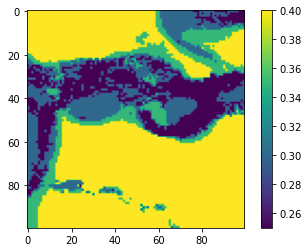

In [22]:
# example input porosity
plt.imshow(porosity_tuple[10])
plt.colorbar()

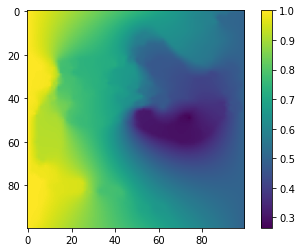

In [23]:
plt.imshow(heads_transformed_tuple[10])
plt.colorbar()

In [24]:
sorter = np.argsort(-popex_object.log_p_lik)

### Convert input to physical features and sample from output

In [25]:
# Choose from different options for X
#X = np.stack([ np.stack([p, h], axis=2) for p,h in zip(porosity_tuple, heads_transformed_tuple) ])
#X = np.stack([ np.stack([p, k, ss], axis=2) for p,k,ss in zip(porosity_tuple, k_tuple, ss_tuple) ])
#X = np.stack([ np.stack([p, vx, vy], axis=2) for p,vx,vy in zip(red_porosity_tuple, vx_tuple, vy_tuple) ])
#X = np.stack([ np.stack([vx, vy, vxp, vyp], axis=2) for vx,vy,vxp,vyp in zip(vxp_tuple, vyp_tuple, vx_tuple, vy_tuple) ])
#X = np.stack([ np.stack([vx**2 + vy**2], axis=2) for vx,vy in zip(vxp_tuple, vyp_tuple) ])
#X = np.stack([ np.stack([vx], axis=2) for vx,vy in zip(vxp_tuple, vyp_tuple) ])

# Two channels, 98x98 images, 500 samples
X = np.stack([ np.stack([vx, vy], axis=2) for vx,vy in zip(vxp_tuple, vyp_tuple) ])
X.shape

(500, 98, 98, 2)

In [26]:
# the flat version of the X set
X_flat = X.reshape(X.shape[0], X.shape[-1]*98*98)

### Set auxiliary variables

In [27]:
#Intel(R) Xeon(R) CPU D-1541 @ 2.10GHz
cm = 6.3
cg = 1.7e2
CM = 3.8e2
CG = 1.05e4
C = cm/cg
C

0.03705882352941176

In [28]:
def weights(ratio):
    return {0:ratio, 1:1-ratio}

In [29]:
def speedup_est(precision, recall):
    return (1+C)/(C/recall+ RATIO/precision)

In [30]:
# number of folds in K-fold
K = 5

In [31]:
KFOLD = StratifiedKFold(random_state=1430, shuffle=True, n_splits=K)

In [32]:
EPOCHS_MAX = 300

In [33]:
DPI=300

# Case 1. Ratio r=0.4

In [34]:
# we will call set with ratio 0.4 "balanced"
RATIO = 0.4
y_balanced = np.zeros((N_POPEX,))
y_balanced[sorter[:int(RATIO*N_POPEX)]] = 1
y_balanced.shape

(500,)

## Random Forest

In [35]:
rf_n_estimators = [10, 100, 1000, 10000]
rf_max_samples = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.4, 0.6, 0.8, None]
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced', random_state=1234),
                              param_grid = {'n_estimators': rf_n_estimators,
                                            'max_samples' : rf_max_samples,
                                           },
                               return_train_score = True,
                               n_jobs=44,
                               cv = KFOLD,
                               scoring={'balanced_accuracy': 'balanced_accuracy',
                                        'precision':'precision',
                                        'recall': 'recall',
                                       },
                               refit=False,
                              )

In [36]:
def speedup_from_kfold_df(row):
    speedups = np.zeros(5)
    for i in range(K):
        try:
            speedups[i] = speedup_est(precision=row[f'split{i}_test_precision'], recall=row[f'split{i}_test_recall'])
        except ZeroDivisionError:
            speedups[i] = 0
    row['mean_test_speedup'], row['std_test_speedup'] = np.mean(speedups), np.std(speedups)
    return row

In [37]:
try:
    #raise FileNotFoundError
    df_rf = pd.read_csv('df_rf.csv')
except FileNotFoundError:
    grid_search_rf.fit(X_flat, y_balanced)
    df_rf = pd.DataFrame(grid_search_rf.cv_results_)
    df_rf.to_csv('df_rf.csv')
    
df_rf = df_rf.apply(lambda row: speedup_from_kfold_df(row), axis=1)

In [38]:
df_rf.sort_values(by='mean_test_speedup', ascending=False)[['param_max_samples', 'param_n_estimators', 'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'mean_test_speedup', 'std_test_speedup']].head()

,param_max_samples,param_n_estimators,mean_test_balanced_accuracy,std_test_balanced_accuracy,mean_test_speedup,std_test_speedup
19,0.08,10000,0.790000,0.035901,2.015749,0.073168
26,0.20,1000,0.841667,0.023124,2.013926,0.035350
22,0.10,1000,0.804167,0.050553,2.012979,0.116449
11,0.04,10000,0.734167,0.030664,2.008964,0.072476
42,NaN,1000,0.856667,0.018745,2.008770,0.044479


In [39]:
def plot_accuracy_samples(df, score, title, y_range, plot_legend=True):
    legend = []
    fig, ax = plt.subplots(figsize=(3.54330709,3.54330709))
    ax.set_title(title)
    for n_estimators in rf_n_estimators:
        df_current = df[df['param_n_estimators']==n_estimators]
        ax.errorbar(df_current['param_max_samples'], df_current[f'mean_test_{score}'], yerr=df_current[f'std_test_{score}']/sqrt(5))
        legend.append(f'n={n_estimators}')
    ax.set(xlabel='sample fraction', ylabel=f'5-fold validated s-score')
    ax.set_xscale("log", nonposx='clip')
    ax.set_ylim(y_range)
    if plot_legend == True:
        plt.legend(legend)
    plt.tight_layout()
    plt.savefig(f'ML-{title}.eps', dpi=DPI)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


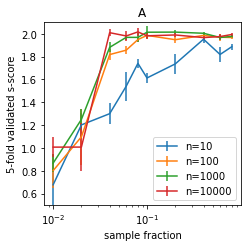

In [40]:
plot_accuracy_samples(df=df_rf, score='speedup', title='A', y_range=[0.5,2.1], plot_legend=True)
#plt.ylim([1.8,2.2])
#plt.xlim([0.0, 0.2])

A suitable choice seems to be n=1000 (sufficiently large) and n_samples 0.4 (for lower goes down).

In [41]:
def df_to_print(df):
    df = df.copy()
    df['speedup_err'] = df['std_test_speedup']/sqrt(5)
    df['precision_err'] = df['std_test_precision']/sqrt(5)
    df['recall_err'] = df['std_test_recall']/sqrt(5)
    df['a_speedup_err'] = df['precision_err']/RATIO
    df['a_speedup'] = df['mean_test_precision']/RATIO
    
    return df[['mean_test_speedup', 'speedup_err',
               'mean_test_precision', 'precision_err',
               'a_speedup', 'a_speedup_err',
               'mean_test_recall', 'recall_err',
              ]]

In [42]:
df_to_print(
    df_rf[(df_rf['param_n_estimators']==1000) & (df_rf['param_max_samples']==0.2)]
)

,mean_test_speedup,speedup_err,mean_test_precision,precision_err,a_speedup,a_speedup_err,mean_test_recall,recall_err
26,2.013926,0.015809,0.857927,0.010536,2.144817,0.026339,0.77,0.029496


### AdaBoost

In [43]:
n_estimators_ada = [10, 20, 50, 100, 200, 500, 1000]
learning_rate_ada = [0.0001, 0.001, 0.01, 0.1]
grid_search_ada = GridSearchCV(estimator=AdaBoostClassifier(random_state=123),
                          param_grid = {'n_estimators': n_estimators_ada,
                                       'learning_rate': learning_rate_ada,
                                       },
                           return_train_score = True,
                           n_jobs=44,
                           cv = KFOLD,
                           scoring={'balanced_accuracy': 'balanced_accuracy',
                                    'precision':'precision',
                                    'recall': 'recall',
                                   },
                           refit=False,
                          )

In [44]:
try:
    #raise FileNotFoundError
    df_ada = pd.read_csv('df_ada.csv')
except FileNotFoundError:
    grid_search_ada.fit(X_flat, y_balanced)
    df_ada = pd.DataFrame(grid_search_ada.cv_results_)
    df_ada.to_csv('df_ada.csv')
df_ada = df_ada.apply(lambda row: speedup_from_kfold_df(row), axis=1)

In [45]:
df_ada.sort_values(by='mean_test_speedup', ascending=False).head()[['mean_test_speedup', 'mean_test_recall', 'mean_test_precision']]

,mean_test_speedup,mean_test_recall,mean_test_precision
18,1.978717,0.785,0.839977
21,1.968058,0.755,0.838413
23,1.954822,0.830,0.824238
17,1.952100,0.745,0.832276
13,1.952100,0.745,0.832276


In [46]:
def plot_accuracy_learningrates(df, score='speedup'):
    legend = []
    for n_estimators in n_estimators_ada:
        df_current = df[df['param_n_estimators']==n_estimators]
        #plt.errorbar(df_current['param_learning_rate'], df_current[f'mean_test_{score}'], yerr=df_current[f'std_test_{score}'])
        plt.semilogx(df_current['param_learning_rate'], df_current[f'mean_test_{score}'])
        legend.append(f'n={n_estimators}, test set')
    plt.legend(legend)
    plt.xlabel('learning rate')
    plt.ylabel(f'5-fold {score}, test set')

In [47]:
def plot_accuracy_n_estimators(df, score, title, y_range, plot_legend=True):
    fig, ax = plt.subplots(figsize=(3.54330709,3.54330709))
    ax.set_title(title)
    legend = []
    for learning_rate in learning_rate_ada:
        df_current = df[df['param_learning_rate']==learning_rate]
        ax.errorbar(df_current['param_n_estimators'], df_current[f'mean_test_{score}'], yerr=df_current[f'std_test_{score}']/sqrt(5))
        legend.append(f'rate={learning_rate}')
    ax.set(xlabel='#estimators', ylabel=f'5-fold validated s-score')
    if plot_legend is True:
        ax.legend(legend)
    ax.set_xscale("log", nonposx='clip')
    ax.set_ylim(y_range)
    plt.tight_layout()
    plt.savefig(f'ML-{title}.eps', dpi=DPI)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


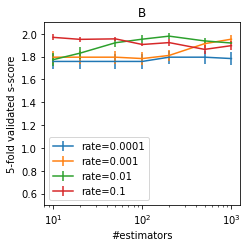

In [48]:
plot_accuracy_n_estimators(df=df_ada, score='speedup', title='B', y_range=[0.5,2.1])

In [49]:
df_to_print(
    df_ada[(df_ada['param_n_estimators']==200) & (df_ada['param_learning_rate']==0.01)]
)

,mean_test_speedup,speedup_err,mean_test_precision,precision_err,a_speedup,a_speedup_err,mean_test_recall,recall_err
18,1.978717,0.025252,0.839977,0.010267,2.099942,0.025667,0.785,0.045056


Learning rate 0.01 and n=200

In [50]:
#classifiers_balanced = [
#    #LogisticRegression(max_iter=10000, class_weight='balanced'),
#    AdaBoostClassifier(random_state=123, learning_rate=0.1, n_estimators=50),
#    RandomForestClassifier(class_weight='balanced', random_state=1234, n_estimators=1000, max_samples=0.4),
#]

In [51]:
#def print_classifiers_scores(y, classifiers):
#    for classifier in classifiers:
#        print(str(classifier))
#        score = cross_validate(classifier,
#                               X_flat, y,
#                               cv=KFOLD,
#                               scoring={'balanced_accuracy': 'balanced_accuracy',
#                                        'precision':'precision',
#                                        'recall': 'recall',
#                                       }
#                              )
#
#        print(f'Mean precision: {np.mean(score["test_precision"])} +- {np.std(score["test_precision"])/sqrt(K)}')
#        print(f'Mean recall: {np.mean(score["test_recall"])} +- {np.std(score["test_recall"])/sqrt(K)}')
#        print(f'Mean speedup approx: {np.mean(score["test_precision"])/RATIO} +- {np.std(score["test_precision"])/RATIO/sqrt(K)}')
#        speedups = speedup_est(precision=score["test_precision"], recall=score['test_recall'])
#        print(f'Mean speedup: {np.mean(speedups)} +- {np.std(speedups)/sqrt(K)}')

In [52]:
#print_classifiers_scores(y_balanced, classifiers_balanced)

## CNN 

https://keras.io/examples/vision/mnist_convnet/

In [53]:
def build_CNN_model(kernel_factor, number_blocks):
    """
    The base keras CNN model inspired by AlexNet
    
    kernel_factor : divides number of kernels or nodes in a dense network
    number_blocks : number of blocks in the net, included from 1 up to number_blocks,
                    for example number blocks=3 will give network composed of blocks: 1,2,3
    """
    model = None
    k = kernel_factor
    block_input = [    keras.layers.Input(shape=X.shape[1:]),]
    
    block1 = [keras.layers.Convolution2D(24/k, kernel_size=(5, 5), activation="relu",  strides=(2,2), padding='valid'),
    keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),]
    
    block2 = [keras.layers.Convolution2D(64/k, kernel_size=(5, 5), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),]
    
    block3 = [    keras.layers.Convolution2D(96/k, kernel_size=(3, 3), activation="relu", padding='valid'),
    keras.layers.Convolution2D(96/k, kernel_size=(3, 3), activation="relu", padding='valid'),
    keras.layers.Convolution2D(64/k, kernel_size=(3, 3), activation="relu", padding='valid'),
    keras.layers.MaxPooling2D(pool_size=(3, 3),  strides=(2,2), padding='valid'),]
    block4 = [    keras.layers.Flatten(),
    keras.layers.Dense(1024/k, activation='relu'),]
    block5 = [    keras.layers.Flatten(),
              keras.layers.Dense(1024/k, activation='relu'),]
    block_output = [    keras.layers.Dense(1, activation="sigmoid"),]
    building_blocks = [block1, block2, block3, block4, block5]
    model_list = block_output
    for i in range(number_blocks):
        model_list = building_blocks[4-i] + model_list
    model_list = block_input + model_list
    model =  keras.Sequential(model_list)
    model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=[keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall'), 'accuracy'],
              weighted_metrics=['accuracy'])
    return model

In [54]:
# The basic net
modelCNN = build_CNN_model(kernel_factor=1, number_blocks=5)
modelCNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 47, 47, 24)        1224      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 19, 64)        38464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 96)          55392     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 96)          83040     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 64)          5

In [55]:
def train_test_modelCNN(model, X_train, y_train, X_test, y_test, epochs, verbose=1):
    return model.fit(X_train, y_train,
                     batch_size=len(X),
                     epochs=epochs,
                     verbose=verbose,
                     validation_data=(X_test, y_test),
                     class_weight=weights(RATIO),
                    )

In [56]:
def K_fold_validate(y, kernel_factor, number_blocks, epochs):
    train_losses = np.zeros((K, epochs))
    val_losses = np.zeros((K, epochs))
    val_precisions = np.zeros((K, epochs))
    val_recalls = np.zeros((K, epochs))
    for i, (train, test) in enumerate(KFOLD.split(X, y)):
        keras.backend.clear_session()
        strategy = tf.distribute.MirroredStrategy()
        with strategy.scope():
            model = None
            model = build_CNN_model(kernel_factor=kernel_factor, number_blocks=number_blocks)
        history = train_test_modelCNN(model,
                              X[train], y[train], X[test], y[test],
                              epochs=epochs,
                              verbose=0)
        train_losses[i,:] = np.array(history.history['loss'])
        val_losses[i,:] = np.array(history.history['val_loss'])
        val_precisions[i,:] = np.array(history.history['val_precision'])
        val_recalls[i,:] = np.array(history.history['val_recall'])
        del model
        
    return {'train_losses' : train_losses,
            'val_losses':val_losses,
            'val_precisions':val_precisions,
            'val_recalls':val_recalls}

In [57]:
try:
    with open('example-data.pickle', 'rb') as fh:
        data = pickle.load(fh)
except FileNotFoundError:
    data = K_fold_validate(y=y_balanced, kernel_factor=2, number_blocks=3, epochs=EPOCHS_MAX)
    with open('example-data.pickle', 'wb') as fh:
        pickle.dump(data, fh)

In [58]:
def plot_learning_curve(data):
    plt.title(f'5-fold loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(np.mean(data['train_losses'], axis=0))
    plt.plot(np.mean(data['val_losses'], axis=0))
    plt.legend(['5-fold train', '5-fold test'])
    #plt.plot(np.mean(data['val_losses'], axis=0)+np.std(data['val_losses'], axis=0))
    #plt.plot(np.mean(data['val_losses'], axis=0)-np.std(data['val_losses'], axis=0))

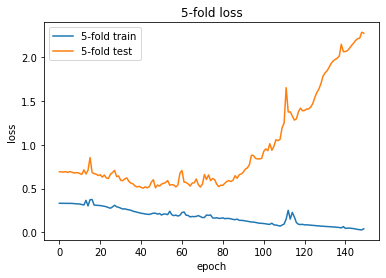

In [59]:
plot_learning_curve(data)

In [60]:
def min_loss_5_fold(data):    
    epoch_min_loss = int(np.argmin(np.mean(data['val_losses'], axis=0)))
    min_loss = np.mean(data['val_losses'], axis=0)[epoch_min_loss]
    speedups = speedup_est(data['val_precisions'], data['val_recalls'])[:,epoch_min_loss]
    mean_speedup = np.mean(speedups)
    std_speedup = np.std(speedups)/sqrt(K)
    return epoch_min_loss, min_loss, mean_speedup, std_speedup

In [61]:
epoch_min_loss, _, _, _ = min_loss_5_fold(data)
epoch_min_loss

41

In [62]:
def evaluate_models(row, y):
    kernel_factor = row['kernel_factor']
    number_blocks = row['number_blocks']
    data_name = f'ml-{RATIO}/model-{kernel_factor}-{number_blocks}.pickle'
    try:
        with open(data_name, 'rb') as fh:
            data = pickle.load(fh)
    except FileNotFoundError:
        data = K_fold_validate(y=y, kernel_factor=kernel_factor, number_blocks=number_blocks)
        with open(data_name, 'wb') as fh:
            pickle.dump(data, fh)
            
    row['epoch_min_loss'], row['min_loss'], row['mean_test_speedup'], row['std_test_speedup'] = min_loss_5_fold(data)
    row['mean_test_precision'] = np.mean(data['val_precisions'][:,int(row['epoch_min_loss'])])
    row['std_test_precision'] = np.std(data['val_precisions'][:,int(row['epoch_min_loss'])])
    #row['precision_err'] = np.std(data['val_precisions'][:,int(row['epoch_min_loss'])])/sqrt(5)
    row['mean_test_recall'] = np.mean(data['val_recalls'][:,int(row['epoch_min_loss'])])
    row['std_test_recall'] = np.std(data['val_recalls'][:,int(row['epoch_min_loss'])])
    #row['recall_err'] = np.std(data['val_recalls'][:,int(row['epoch_min_loss'])])/sqrt(5)
    #row['speedup_err'] = row['std_test_speedup']/sqrt(5)
    #row['a_speedup'] = row['mean_test_precision'] / RATIO
    #row['a_speedup_err'] = row['precision_err'] / RATIO
    
    row['data_name'] = data_name
    return row

In [63]:
def evaluate_balanced(row):
    return evaluate_models(row, y=y_balanced)

In [64]:
factors = [1, 2, 4, 8]
blocks_n = [1 , 2, 3, 4, 5]

index = pd.MultiIndex.from_product([factors, blocks_n], names = ["kernel_factor", "number_blocks"])

df = pd.DataFrame(index = index).reset_index()
df.head()

,kernel_factor,number_blocks
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5


In [65]:
df_evaluation = df.apply(evaluate_balanced, axis=1)
df_evaluation['number_blocks'] = pd.to_numeric(df_evaluation['number_blocks'], downcast='integer')
df_evaluation['kernel_factor'] = pd.to_numeric(df_evaluation['kernel_factor'], downcast='integer')

In [66]:
df_evaluation.sort_values(by='mean_test_speedup', ascending=False).head()

,kernel_factor,number_blocks,epoch_min_loss,min_loss,mean_test_speedup,std_test_speedup,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,data_name
16,8,2,44.0,0.423348,1.815875,0.020349,0.762613,0.020574,0.800,0.057009,ml-0.4/model-8-2.pickle
5,2,1,75.0,0.417592,1.807137,0.029072,0.756188,0.030048,0.830,0.048477,ml-0.4/model-2-1.pickle
12,4,3,56.0,0.398146,1.806819,0.039774,0.757651,0.042042,0.815,0.071764,ml-0.4/model-4-3.pickle
17,8,3,62.0,0.411734,1.790586,0.019784,0.751020,0.017631,0.800,0.067082,ml-0.4/model-8-3.pickle
15,8,1,136.0,0.420995,1.788633,0.026106,0.748131,0.027322,0.825,0.041833,ml-0.4/model-8-1.pickle


In [67]:
df_to_print(
    df_evaluation.sort_values(by='mean_test_speedup', ascending=False).head(1)
)

,mean_test_speedup,speedup_err,mean_test_precision,precision_err,a_speedup,a_speedup_err,mean_test_recall,recall_err
16,1.815875,0.0091,0.762613,0.009201,1.906533,0.023003,0.8,0.025495


In [68]:
df_evaluation.to_csv("df_evaluation.csv")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


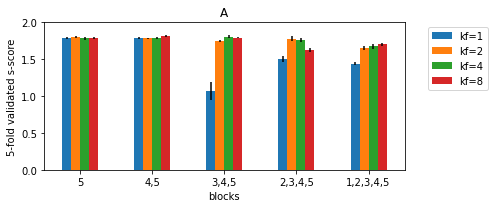

In [69]:
fig, ax = plt.subplots(figsize=(7.08661417,3))
df_evaluation.pivot(index='number_blocks',
                    columns='kernel_factor',
                    values='mean_test_speedup',
                   ).plot.bar(ax=ax, yerr=df_evaluation.pivot(
                    index='number_blocks',
                    columns='kernel_factor',
                    values='std_test_speedup',)/sqrt(5)
                         )
ax.legend(loc='lower right')
ax.set_title('A')
ax.set_ylabel('5-fold validated s-score')
ax.set_xlabel('blocks')
ax.set_xticklabels(['5', '4,5', '3,4,5', '2,3,4,5', '1,2,3,4,5'], rotation=0)
ax.set_ylim([0,2])
ax.legend(['kf=1', 'kf=2', 'kf=4', 'kf=8'], bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig('CNN-A.eps', dpi=DPI)

# Case 1. Ratio r=0.2

In [70]:
RATIO=0.2

In [71]:
y_imbalanced = np.zeros((N_POPEX,))
y_imbalanced[sorter[:int(RATIO*N_POPEX)]] = 1
y_imbalanced.shape

(500,)

In [72]:
try:
    #raise FileNotFoundError
    df_rf_im = pd.read_csv('df_rf_im.csv')
except FileNotFoundError:
    grid_search_rf.fit(X_flat, y_imbalanced)
    df_rf_im = pd.DataFrame(grid_search_rf.cv_results_)
    df_rf_im.to_csv('df_rf_im.csv')
df_rf_im = df_rf_im.apply(lambda row: speedup_from_kfold_df(row), axis=1)

In [73]:
df_rf_im.sort_values(by='mean_test_speedup', ascending=False).head(10)[['param_n_estimators','param_max_samples','mean_test_speedup', 'mean_test_recall']]

,param_n_estimators,param_max_samples,mean_test_speedup,mean_test_recall
43,10000,NaN,2.812413,0.25
37,100,0.8,2.686161,0.25
33,100,0.6,2.685019,0.25
42,1000,NaN,2.645857,0.23
35,10000,0.6,2.634945,0.22
38,1000,0.8,2.633318,0.22
30,1000,0.4,2.622406,0.21
34,1000,0.6,2.588788,0.23
39,10000,0.8,2.573111,0.22
31,10000,0.4,2.548033,0.20


In [74]:
df_rf_im[df_rf_im["param_n_estimators"] == 1000].sort_values(by="mean_test_speedup", ascending=False)

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_samples,param_n_estimators,params,split0_test_balanced_accuracy,split1_test_balanced_accuracy,...,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall,mean_test_speedup,std_test_speedup
42,42,14.321501,0.164101,0.078666,0.002821,NaN,1000,"{'max_samples': None, 'n_estimators': 1000}",0.600,0.675,...,7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.000000,2.645857,0.391048
38,38,12.379666,0.184349,0.081151,0.001093,0.80,1000,"{'max_samples': 0.8, 'n_estimators': 1000}",0.600,0.675,...,8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.000000,2.633318,0.400192
30,30,6.458363,0.196361,0.085430,0.002028,0.40,1000,"{'max_samples': 0.4, 'n_estimators': 1000}",0.600,0.675,...,11,0.8375,0.8375,0.8625,0.8250,0.8750,0.8475,0.018371,2.622406,0.459442
34,34,9.632237,0.155976,0.085911,0.003876,0.60,1000,"{'max_samples': 0.6, 'n_estimators': 1000}",0.600,0.700,...,6,0.9875,1.0000,0.9875,1.0000,0.9875,0.9925,0.006124,2.588788,0.562006
26,26,3.307353,0.065396,0.083478,0.001968,0.20,1000,"{'max_samples': 0.2, 'n_estimators': 1000}",0.525,0.575,...,21,0.3375,0.3125,0.4125,0.3125,0.3625,0.3475,0.037417,1.268203,0.783728
22,22,2.068312,0.036422,0.082851,0.001966,0.10,1000,"{'max_samples': 0.1, 'n_estimators': 1000}",0.525,0.500,...,25,0.1125,0.0125,0.0750,0.0750,0.0375,0.0625,0.034460,0.220375,0.440750
2,2,1.346718,0.021724,0.082741,0.003670,0.01,1000,"{'max_samples': 0.01, 'n_estimators': 1000}",0.500,0.500,...,28,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000
6,6,1.417620,0.009297,0.085153,0.002733,0.02,1000,"{'max_samples': 0.02, 'n_estimators': 1000}",0.500,0.500,...,28,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000
10,10,1.470820,0.016406,0.084231,0.005646,0.04,1000,"{'max_samples': 0.04, 'n_estimators': 1000}",0.500,0.500,...,28,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000
14,14,1.556494,0.026308,0.083194,0.003879,0.06,1000,"{'max_samples': 0.06, 'n_estimators': 1000}",0.500,0.500,...,28,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000


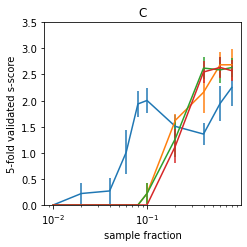

In [75]:
plot_accuracy_samples(df_rf_im, score="speedup", title='C', y_range=[0,3.5], plot_legend=False)

A fair choice is the same as for r=0.4: n=1000 n_samples=0.4

In [76]:
df_to_print(
    df_rf_im[(df_rf_im['param_n_estimators']==1000) & (df_rf_im['param_max_samples']==0.4)]
)

,mean_test_speedup,speedup_err,mean_test_precision,precision_err,a_speedup,a_speedup_err,mean_test_recall,recall_err
30,2.622406,0.205469,0.95,0.044721,4.75,0.223607,0.21,0.032863


## AdaBoost

In [77]:
try:
    #raise FileNotFoundError
    df_ada_im = pd.read_csv('df_ada_im.csv')
except FileNotFoundError:
    grid_search_ada.fit(X_flat, y_imbalanced)
    df_ada_im = pd.DataFrame(grid_search_ada.cv_results_)
    df_ada_im.to_csv('df_ada_im.csv')
df_ada_im = df_ada_im.apply(lambda row: speedup_from_kfold_df(row), axis=1)

In [78]:
df_ada_im.sort_values(by='mean_test_speedup', ascending=False).head()[['mean_test_speedup', 'param_learning_rate', 'param_n_estimators']]

,mean_test_speedup,param_learning_rate,param_n_estimators
19,3.071584,0.01,500
27,3.045880,0.10,1000
26,2.931096,0.10,500
25,2.810262,0.10,200
20,2.726216,0.01,1000


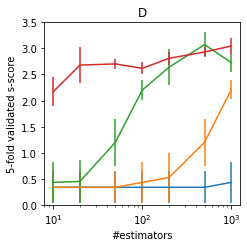

In [79]:
plot_accuracy_n_estimators(df_ada_im, score='speedup', title='D', y_range=[0,3.5], plot_legend=False)
#plt.ylim([2,3.5])

In [80]:
#df_ada_im[df_ada_im['param_learning_rate'] == 0.01].sort_values(by='mean_test_speedup', ascending=False)

Hm ?

In [81]:
df_to_print(
    df_ada_im[(df_ada_im['param_n_estimators']==500) & (df_ada_im['param_learning_rate']==0.01)]
)

,mean_test_speedup,speedup_err,mean_test_precision,precision_err,a_speedup,a_speedup_err,mean_test_recall,recall_err
19,3.071584,0.23542,0.772894,0.057125,3.864469,0.285625,0.48,0.0502


## CNN

In [82]:
def evaluate_imbalanced(row):
    return evaluate_models(row, y=y_imbalanced)

In [83]:
df_evaluation_imbalanced = df.apply(evaluate_imbalanced, axis=1)

In [84]:
df_evaluation_imbalanced.to_csv('df_evaluation_imbalanced.csv')

In [85]:
df_evaluation_imbalanced.sort_values(by='mean_test_speedup', ascending=False).head()

,kernel_factor,number_blocks,epoch_min_loss,min_loss,mean_test_speedup,std_test_speedup,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,data_name
0,1.0,1.0,82.0,0.347295,2.482515,0.126971,0.558479,0.063604,0.63,0.102956,ml-0.2/model-1-1.pickle
1,1.0,2.0,19.0,0.362903,2.482088,0.117372,0.558332,0.065473,0.63,0.060000,ml-0.2/model-1-2.pickle
6,2.0,2.0,26.0,0.351800,2.470092,0.129736,0.557589,0.069077,0.61,0.066332,ml-0.2/model-2-2.pickle
16,8.0,2.0,56.0,0.341335,2.466143,0.099026,0.563523,0.048642,0.57,0.081240,ml-0.2/model-8-2.pickle
5,2.0,1.0,105.0,0.346920,2.463037,0.130464,0.553241,0.065146,0.63,0.102956,ml-0.2/model-2-1.pickle


In [86]:
df_to_print(
df_evaluation_imbalanced.sort_values(by='mean_test_speedup', ascending=False).head(1)
)

,mean_test_speedup,speedup_err,mean_test_precision,precision_err,a_speedup,a_speedup_err,mean_test_recall,recall_err
0,2.482515,0.056783,0.558479,0.028444,2.792393,0.142222,0.63,0.046043


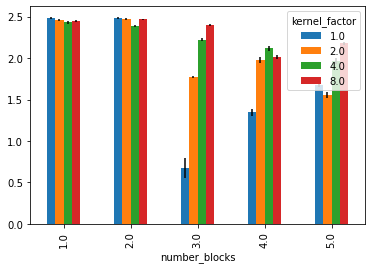

In [87]:
df_evaluation_imbalanced.pivot(index='number_blocks',
                    columns='kernel_factor',
                    values='mean_test_speedup',
                   ).plot.bar(yerr=df_evaluation.pivot(
                    index='number_blocks',
                    columns='kernel_factor',
                    values='std_test_speedup',)/sqrt(5)
                         )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


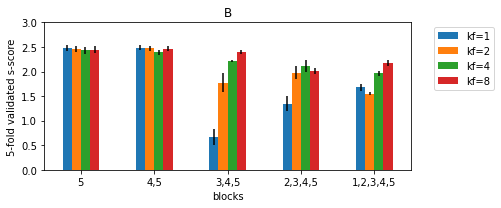

In [88]:
fig, ax = plt.subplots(figsize=(7.08661417,3))
df_evaluation_imbalanced.pivot(index='number_blocks',
                    columns='kernel_factor',
                    values='mean_test_speedup',
                   ).plot.bar(ax=ax, yerr=df_evaluation_imbalanced.pivot(
                    index='number_blocks',
                    columns='kernel_factor',
                    values='std_test_speedup',)/sqrt(5)
                         )
ax.legend(loc='lower right')
ax.set_title('B')
ax.set_ylabel('5-fold validated s-score')
ax.set_xticklabels(['5', '4,5', '3,4,5', '2,3,4,5', '1,2,3,4,5'], rotation=0)
ax.set_xlabel('blocks')
ax.set_ylim([0,3])
ax.legend(['kf=1', 'kf=2', 'kf=4', 'kf=8'], bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig('CNN-B.eps', dpi=DPI)